In [12]:
# heart_disease_model.ipynb

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('heart_dataset.csv')
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Dataset Shape: (5, 17)
Columns: ['age', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'sex_Female', 'sex_Male', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina']


,age,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina
0,58,130,220,1,normal,150,False,1.4,flat,0,fixed defect,0,1,0,0,0,1
1,67,160,276,0,lv hypertrophy,108,True,1.5,flat,3,normal,0,1,1,0,0,0
2,42,120,230,0,normal,170,False,1.0,upsloping,0,reversable defect,1,0,0,0,1,0
3,50,130,210,0,lv hypertrophy,158,False,0.8,flat,0,normal,0,1,0,0,1,0
4,45,114,230,0,normal,165,False,1.1,downsloping,0,normal,1,0,0,1,0,0


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 5 non-null      int64  
 1   trestbps            5 non-null      int64  
 2   chol                5 non-null      int64  
 3   fbs                 5 non-null      int64  
 4   restecg             5 non-null      int64  
 5   thalch              5 non-null      int64  
 6   exang               5 non-null      bool   
 7   oldpeak             5 non-null      float64
 8   slope               5 non-null      object 
 9   ca                  5 non-null      int64  
 10  thal                5 non-null      int64  
 11  sex_Female          5 non-null      int64  
 12  sex_Male            5 non-null      int64  
 13  cp_asymptomatic     5 non-null      int64  
 14  cp_atypical angina  5 non-null      int64  
 15  cp_non-anginal      5 non-null      int64  
 16

FileNotFoundError: [Errno 2] No such file or directory: 'static/feature_importance.png'

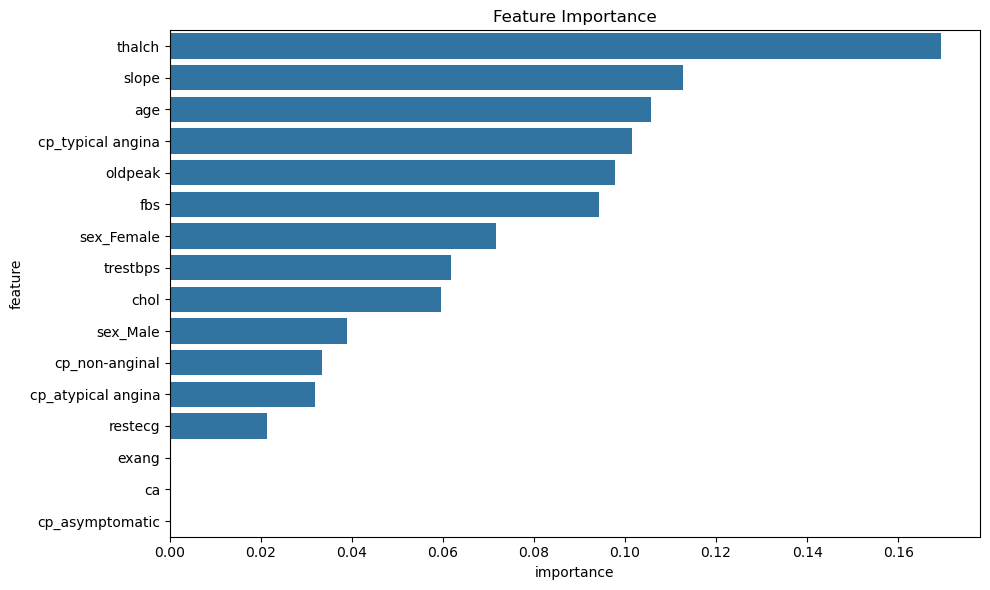

In [14]:
# Data Preprocessing
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Identify categorical columns that need encoding
categorical_cols = ['restecg', 'thal', 'slope']
print(f"\nCategorical columns: {categorical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col} classes: {le.classes_}")

# Let's assume we're predicting 'thal' as our target for this example
X = df.drop('thal', axis=1)
y = df['thal']

print("\nData Types after encoding:")
print(X.dtypes)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale only the numerical features (not the one-hot encoded ones)
numerical_cols = ['age', 'trestbps', 'chol', 'fbs', 'thalch', 'oldpeak', 'ca']
print(f"\nNumerical columns to scale: {numerical_cols}")

# Scale the numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Train different models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Select the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")

# Save the model, scaler, and label encoders
import joblib

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

joblib.dump(best_model, 'models/heart_disease_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(label_encoders, 'models/label_encoders.pkl')
joblib.dump(numerical_cols, 'models/numerical_cols.pkl')

print("Model and preprocessing objects saved successfully!")

# Feature importance (if using Random Forest)
if best_model_name == 'Random Forest':
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('static/feature_importance.png')
    plt.show()

# Display classification report for the best model
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('static/confusion_matrix.png')
plt.show()